##### Initialization: definition of robots and coordinates

In [51]:
import numpy as np
from UAV import *
import random
import matplotlib.pyplot as plt   


n_robots = 5#int(input("number of robots: "))
n_components = 2
platoon = []


# initialization of n robots
for i in range(n_robots):
    if i==0:
        i_robot = Robot("op_" + str(i),0,0,0)
    else:
        i_robot = Robot("op_" + str(i),random.uniform(0, 10.0),random.uniform(0, 10.0),0)
    platoon.append(i_robot)

coordinates = [[],[],[]]

for rob in platoon:
    coordinates = np.append(coordinates,rob.get_coords(),axis=1)

#TRUE COORDINATES [REALITY: THEY ARE UNKNOWN]
S = coordinates[0:2,:]

print(S)

[[0.         8.22624291 0.17258953 9.01860814 6.98333095]
 [0.         3.52297337 2.32921827 5.64049036 7.01509625]]


##### Definition of the (squared) distance matrix

In [52]:
DM2 = d_matrix2(platoon) #squared distance matrix -> for formulas
print(DM2)

#double check the distances
print('\n',DM2 - DM_from_S(S))

[[  0.          80.0824137    5.45504488 113.15042429  97.97848658]
 [ 80.0824137    0.          66.28638398   5.11172087  13.73975235]
 [  5.45504488  66.28638398   0.          89.21656818  68.34365123]
 [113.15042429   5.11172087  89.21656818   0.           6.03189459]
 [ 97.97848658  13.73975235  68.34365123   6.03189459   0.        ]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.42108547e-14
  1.42108547e-14]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.32907052e-15
  1.59872116e-14]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.42108547e-14
  0.00000000e+00]
 [1.42108547e-14 5.32907052e-15 1.42108547e-14 0.00000000e+00
  1.24344979e-14]
 [1.42108547e-14 1.59872116e-14 0.00000000e+00 1.24344979e-14
  0.00000000e+00]]


##### S* estimation through EigenValue Decomposition

In [53]:
S_star = EVD(DM2,n_components)
print(S_star)

[[ 6.42859981 -2.79833102  4.92813553 -4.32602807 -3.32936714]
 [ 0.89828414  1.75006179 -1.11915017  0.36506643 -1.86736819]]


##### Removal of the ambiguity generated by distances in an Universal Euclidean transformation

In [54]:
#Translation removal
S_star = match_anchor(S,S_star,verbose=1)
print(S_star)

X displacement:  -6.428599809822281
Y displacement:  -0.8982841408440302
Displacement matrix:
 [[-6.42859981 -6.42859981 -6.42859981 -6.42859981 -6.42859981]
 [-0.89828414 -0.89828414 -0.89828414 -0.89828414 -0.89828414]]
[[  0.          -9.22693083  -1.50046428 -10.75462788  -9.75796695]
 [  0.           0.85177765  -2.01743431  -0.53321771  -2.76565233]]


The new coordinates may be affected by rotation and flip ambiguities. Thus we must solve the problem with further analysis

##### Identification of rotation ambiguity

DM' : a new acquisition for the distances

We now introduce a displacement for the anchor, in order to build a new (squared) distance matrix.

In reality what we do is applying a displacement to the anchor and we get a new distance matrix

In [55]:
deltaX1 = 0.3
deltaY1 = 0.1

DeltaS_prime = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
DeltaS_prime[:,0] = [deltaX1,deltaY1]

S_prime = S + DeltaS_prime
print(S_prime)

DM_prime = DM_from_S(S_prime,verbose=1)

[[0.3        8.22624291 0.17258953 9.01860814 6.98333095]
 [0.1        3.52297337 2.32921827 5.64049036 7.01509625]]
DM' :
 [[  0.          74.54207328   4.98564751 106.71116133  92.48546876]
 [ 74.54207328   0.          66.28638398   5.11172087  13.73975235]
 [  4.98564751  66.28638398   0.          89.21656818  68.34365123]
 [106.71116133   5.11172087  89.21656818   0.           6.03189459]
 [ 92.48546876  13.73975235  68.34365123   6.03189459   0.        ]]


Estimation of the rotation angle $\theta_r$

In [56]:
"""theta1a, theta1b = estimate_theta2(DM2,DM_prime,S_star,[deltaX1,deltaY1],index=1,verbose=1)
print(theta1a)
print(theta1b)

theta2a, theta2b = estimate_theta2(DM2,DM_prime,S_star,[deltaX1,deltaY1],index=2,verbose=1)
print(theta2a)
print(theta2b)"""

print("------------------------------------")
theta3a, theta3b = estimate_theta3(DM2,DM_prime,S_star,[deltaX1,deltaY1],index=1,verbose=1)
print(theta3a)
print(theta3b)

theta4a, theta4b = estimate_theta3(DM2,DM_prime,S_star,[deltaX1,deltaY1],index=2,verbose=1)
print(theta4a)
print(theta4b)

------------------------------------
1.7096688210742508
2.2595317407523785
2.1658265879972225
-0.2433488819985231


In [57]:
theta_r   = estimate_theta(DM2,DM_prime,S_star,[deltaX1,deltaY1],verbose=1)
theta_r_a = estimate_theta(DM2,DM_prime,S_star,[deltaX1,deltaY1],approx = 1,verbose=1)

Coordinates to work with: 1-th and 2-th
After normalization: 
cos(theta):	-0.833194
sin(theta):	0.552981

Actual theta:	 2.5556546549185635
Approx theta:	Disabled
Coordinates to work with: 1-th and 2-th
After normalization: 
cos(theta):	-0.833194
sin(theta):	0.552981

Actual theta:	 2.5556546549185635
Approx theta:	 2.5557


S** : estimated-rotated coordinates

In [58]:
S_star2 = rotateMatrix(theta_r)@S_star
S_star2a = rotateMatrix(theta_r_a)@S_star

##### Identification of flip ambiguity

We have to check if there is any flip ambiguity. To do so, we have to move the anchor one more time

In [59]:
deltaX2 = 0.7
deltaY2 = 0.4

DeltaS_prime2 = np.array([[0 for i in range(n_robots)] for j in range(2)],dtype=float)
DeltaS_prime2[:,0] = [deltaX2,deltaY2]

S_prime2 = S + DeltaS_prime2
print(S_prime)

DM_prime2 = DM_from_S(S_prime2,verbose=1)

[[0.3        8.22624291 0.17258953 9.01860814 6.98333095]
 [0.1        3.52297337 2.32921827 5.64049036 7.01509625]]
DM' :
 [[ 0.         66.39729494  4.00004492 96.6619806  83.23974625]
 [66.39729494  0.         66.28638398  5.11172087 13.73975235]
 [ 4.00004492 66.28638398  0.         89.21656818 68.34365123]
 [96.6619806   5.11172087 89.21656818  0.          6.03189459]
 [83.23974625 13.73975235 68.34365123  6.03189459  0.        ]]


Now we estimate a second rotation angle $\theta_{r2}$: if = 0, no flip ambiguity

theta_r2 :  -0.0


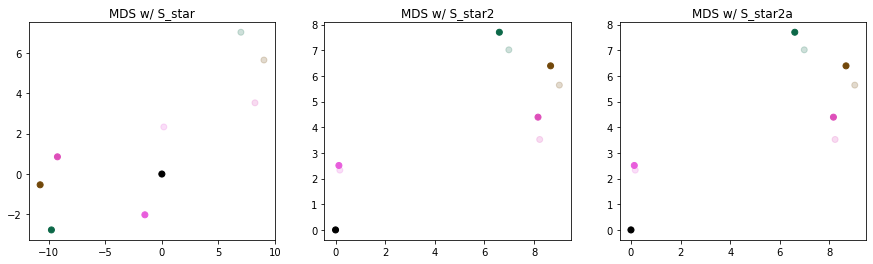

[[ 0.          0.06740475  0.03801523  0.35277868  0.38240745]
 [ 0.         -0.86964972 -0.18142388 -0.75088991 -0.68519989]]


In [60]:
theta_r2 = estimate_theta(DM2,DM_prime2,S_star2,[deltaX2,deltaY2],approx=2,verbose=0)
print("theta_r2 : ", theta_r2)


if (theta_r2 != 0):
  F = np.array([[-1,0],[0,1]])
    
  theta_r3 = estimate_theta(DM2,DM_prime,F@S_star,[deltaX1,deltaY1],verbose=0)
  theta_r3_a = estimate_theta(DM2,DM_prime,F@S_star,[deltaX1,deltaY1],approx=1,verbose=0)

  print("Wrong estimated angle:",theta_r)
  print("True  estimated angle:", theta_r3)

  S_star2 = rotateMatrix(theta_r3)@F@S_star
  S_star2a = rotateMatrix(theta_r3_a)@F@S_star


plot_points(S,S_star  = S_star,
              S_star2 = S_star2,
              S_star2a = S_star2a
            )
print(S-S_star2)

In [77]:
a1 = estimate_theta(DM2,DM_prime,S_star,[deltaX1,deltaY1],index=1,verbose=1)
a2 = estimate_theta(DM2,DM_prime,S_star,[deltaX1,deltaY1],index=2,verbose=1)
a3 = estimate_theta(DM2,DM_prime,S_star,[deltaX1,deltaY1],index=3,verbose=1)

theta_m = (a1+a2+a3)/3
print(theta_m)

Coordinates to work with: 1-th and 2-th
After normalization: 
cos(theta):	-0.833194
sin(theta):	0.552981

Actual theta:	 2.5556546549185635
Approx theta:	Disabled
Coordinates to work with: 2-th and 3-th
After normalization: 
cos(theta):	-0.825075
sin(theta):	0.565023

Actual theta:	 2.5411318415941815
Approx theta:	Disabled
Coordinates to work with: 3-th and 4-th
After normalization: 
cos(theta):	-0.847550
sin(theta):	0.530716

Actual theta:	 2.582147173049937
Approx theta:	Disabled
2.5596445565208943


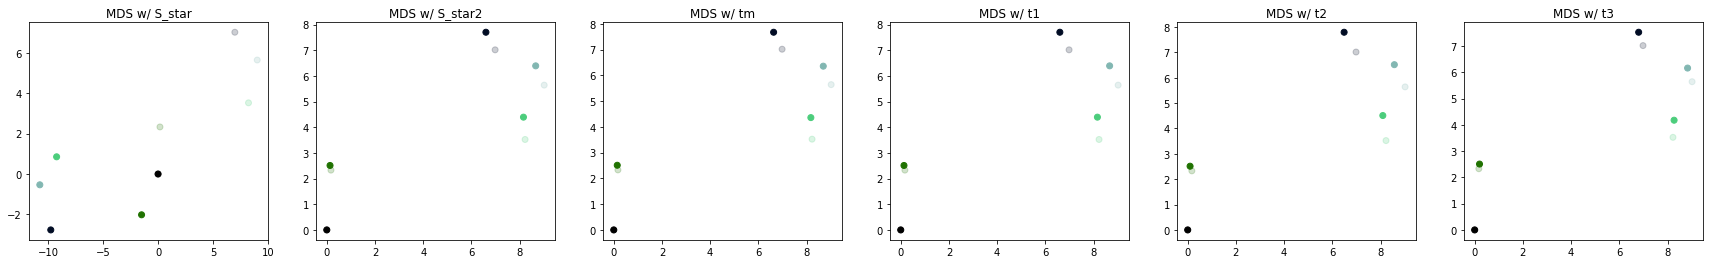

In [78]:
plot_points(S,S_star  = S_star,
              S_star2 = S_star2,
              tm = rotateMatrix(theta_m)@S_star,
              t1 = rotateMatrix(a1)@S_star,              
              t2 = rotateMatrix(a2)@S_star,
              t3 = rotateMatrix(a3)@S_star              
            )